In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt

Set device and reproducibility

In [2]:
torch.manual_seed(101)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create a transformer instance: transform to tensor

In [3]:
transform = transforms.ToTensor()

Import the MNIST Dataset and divide into train and test data

In [4]:
train_data = datasets.MNIST(root = "train_images/MNIST", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root = "train_images/MNIST", train=False, download=True, transform=transform)

Create the dataloaders with a small batch size (for CNN)

In [5]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False)

### Parameters of a convolutional layer
Example:
*conv1 = nn.Conv2d(1,6,3,1)* means:

- 1, for one input channel (grayscale)
- 6, output channels for feature extractions, the feature maps, the filters that the CNN will figure out
- 3, kernel size for a 3 by 3 filter
- 1, for the horizontal and vertical stride of the convolution

### Example: simple training step with convolutional layers and polling layers
- Input
- Convolutional layer
- Pooling layer
- Flattening

In [6]:
# define the convolutional layer
conv1 = nn.Conv2d(1,6,3,1)

for i, (X_train, Y_train) in enumerate(train_data):
    break

print("Shape of X_train:", X_train.shape)

# add an extra dimension to X_train to make the convolution (1 for batch)
x = X_train.view(1,1,28,28)

# perform a convolution 
out = conv1(x)
print("Shape after the convolution:", out.shape)

# perform a pooling
max_p = F.max_pool2d(out,2,2)
print("Shape after the pooling", max_p.shape)

# How to feed this output of max_p to a fully connected input?
x = max_p.view(-1, 6*13*13)
print("Shape after the flattening", x.shape)

Shape of X_train: torch.Size([1, 28, 28])
Shape after the convolution: torch.Size([1, 6, 26, 26])
Shape after the pooling torch.Size([1, 6, 13, 13])
Shape after the flattening torch.Size([1, 1014])


### CNN Model
Architecture of the model:

CNN -> POL -> CNN -> POL -> FLAT -> FCL1 -> FCL2 -> FCL3

In [7]:
class ConvolutionalNN(nn.Module):
    def __init__(self, filter1, filter2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, filter1, 3, 1)  # You can change this to any number of filters
        self.conv2 = nn.Conv2d(6, filter2, 3, 1) # You can change this to any number of filters
        self.pool = nn.MaxPool2d(2, 2)
        
        # Initialize fully connected layers with placeholder
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Dynamically compute the input size for the first fully connected layer
        self._initialize_fc1()

    def _initialize_fc1(self):
        # Create a dummy tensor with the same size as an MNIST input
        dummy_input = torch.zeros(1, 1, 28, 28)

        # Pass the dummy input through the conv and pooling layers to calculate the flattened size
        dummy_output = self.pool(F.relu(self.conv1(dummy_input)))
        dummy_output = self.pool(F.relu(self.conv2(dummy_output)))
        
        # Calculate the flattened size
        flattened_size = dummy_output.numel()  # Returns the total number of elements in the tensor
        
        # Now that we know the flattened size, we can initialize the first fully connected layer
        self.fc1 = nn.Linear(flattened_size, 120)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)  
        X = F.relu(self.conv2(X))
        X = self.pool(X)  
        X = X.view(X.size(0), -1)  # Flattening
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [8]:
model = ConvolutionalNN(filter1=6, filter2=16).to(device)
print(model)

ConvolutionalNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # train 
    for b, (X_trn, Y_trn) in enumerate(train_loader):
        X_trn, Y_trn = X_trn.to(device), Y_trn.to(device)  # Ensure inputs and targets are on the same device
        b += 1
        
        y_pred = model(X_trn)  # Fixed typo: use X_trn instead of X_train
        loss = criterion(y_pred, Y_trn)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == Y_trn).sum()  # Corrected from y_pred to Y_trn
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 600 == 0:
            print(f'epoch: {b:2} - batch: {b:4} [{10*b:6}/60000],  loss: {loss.item():.6f}, accuracy: {trn_corr.item()*100/(10*b):.6f}%')
    
    
    train_losses.append(loss.item())
    train_correct.append(trn_corr)  # Use trn_corr instead of batch_corr for the entire epoch
        
    # test
    with torch.no_grad():
        for b, (X_test, Y_test) in enumerate(test_loader):
            X_test, Y_test = X_test.to(device), Y_test.to(device)  # Ensure test inputs and targets are on the same device
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == Y_test).sum()
        
    loss = criterion(y_val, Y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
        
current_time = time.time()
total = current_time - start_time
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 600 - batch:  600 [  6000/60000],  loss: 0.131692, accuracy: 79.133333%
epoch: 1200 - batch: 1200 [ 12000/60000],  loss: 0.104534, accuracy: 86.766667%
epoch: 1800 - batch: 1800 [ 18000/60000],  loss: 0.060215, accuracy: 89.694444%
epoch: 2400 - batch: 2400 [ 24000/60000],  loss: 0.001005, accuracy: 91.225000%
epoch: 3000 - batch: 3000 [ 30000/60000],  loss: 0.071172, accuracy: 92.303333%
epoch: 3600 - batch: 3600 [ 36000/60000],  loss: 0.066616, accuracy: 93.072222%
epoch: 4200 - batch: 4200 [ 42000/60000],  loss: 0.016452, accuracy: 93.645238%
epoch: 4800 - batch: 4800 [ 48000/60000],  loss: 0.016666, accuracy: 94.085417%
epoch: 5400 - batch: 5400 [ 54000/60000],  loss: 0.244604, accuracy: 94.440741%
epoch: 6000 - batch: 6000 [ 60000/60000],  loss: 0.099205, accuracy: 94.705000%
epoch: 600 - batch:  600 [  6000/60000],  loss: 0.295024, accuracy: 97.750000%
epoch: 1200 - batch: 1200 [ 12000/60000],  loss: 1.164779, accuracy: 97.775000%
epoch: 1800 - batch: 1800 [ 18000/60000], 

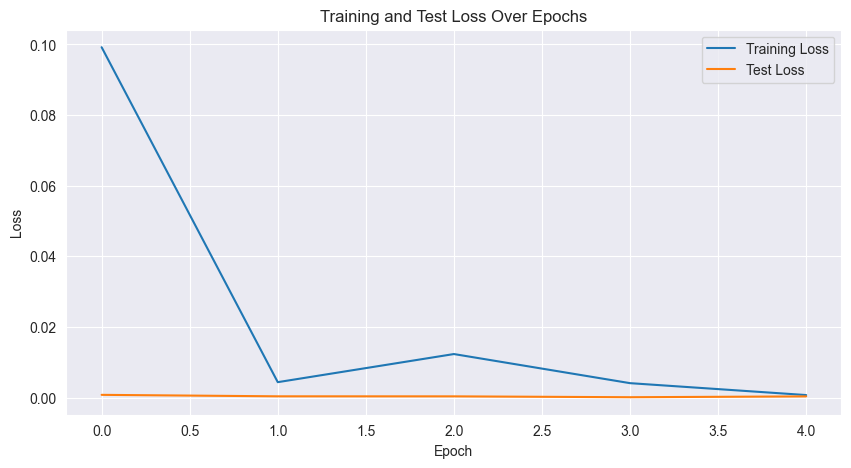

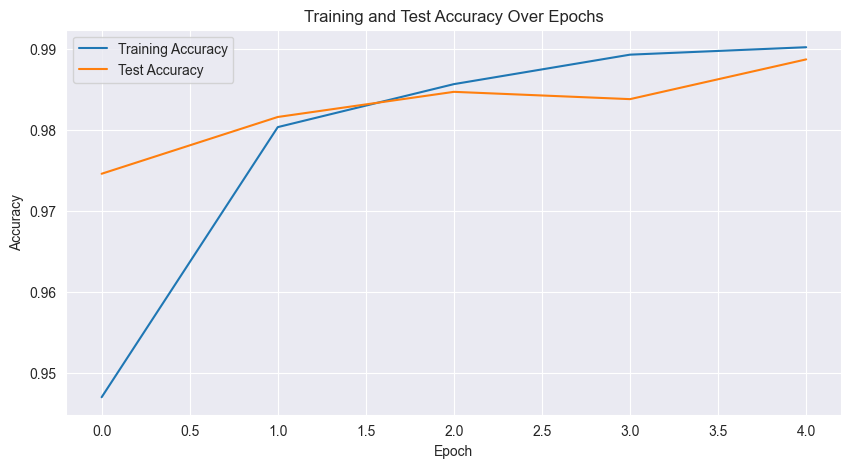

In [13]:


# Plot training and testing loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and testing accuracy
train_acc = [float(x) / len(train_data) for x in train_correct]  # Convert to accuracy percentages
test_acc = [float(x) / len(test_data) for x in test_correct]  # Convert to accuracy percentages

plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Evaluation with the entire test data

In [14]:
# Extract the data all at one
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, Y_test in test_load_all:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == Y_test).sum()
print(f'Entire Test Dataset Accuracy: {correct.item()/len(test_data)} = {correct.item()*100/(len(test_data)):.7f}%')

Test Accuracy: 0.9887 = 98.8700000%


In [15]:
# count the number of parameters used in the mode
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    54
     6
   864
    16
 10080
    84
   840
    10
 48000
   120
______
 60074


Confusion Matrix

In [21]:
def print_confusion_matrix():
    np.set_printoptions(formatter=dict(int=lambda x: f"{x:4}"))
    print(np.arange(10).reshape(1,10))
    print()

    # Move tensors to CPU and convert to numpy for confusion matrix computation
    predicted_cpu = predicted.view(-1).cpu().numpy()
    y_test_cpu = Y_test.view(-1).cpu().numpy()

    # Print the confusion matrix
    print(confusion_matrix(predicted_cpu, y_test_cpu))

In [22]:
print_confusion_matrix()

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 973    0    1    0    0    2    2    0    9    0]
 [   0 1133    1    1    0    0    3    2    0    3]
 [   0    2 1017    2    0    0    0    3    2    0]
 [   0    0    0 1000    0    4    0    2    1    2]
 [   0    0    0    0  972    0    4    1    0    5]
 [   0    0    0    4    0  881    1    0    0    1]
 [   0    0    0    0    0    2  948    0    6    0]
 [   3    0   10    0    2    0    0 1016    1    1]
 [   0    0    2    2    0    3    0    2  953    3]
 [   4    0    1    1    8    0    0    2    2  994]]


In [37]:
def print_sample(ide):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Ensure the input tensor is moved to the same device as the model
        device = next(model.parameters()).device
        input_tensor = test_data[ide][0].view(1, 1, 28, 28).to(device)
        
        # Perform the prediction and move the result to CPU and NumPy
        new_prediction = model(input_tensor).argmax().cpu().numpy()

    # Move the image tensor to the CPU, convert to NumPy, and reshape for display
    plt.imshow(test_data[ide][0].cpu().numpy().reshape(28, 28), cmap='gray')
    
    # Print the predicted class
    print(f"Prediction: {new_prediction}")

Prediction: 5


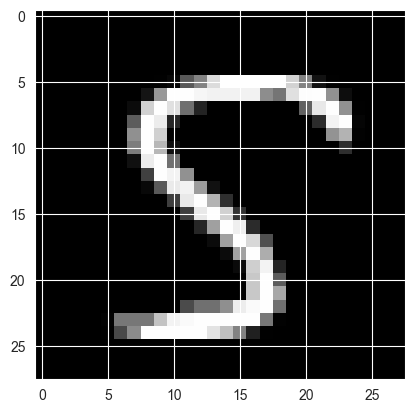

In [38]:
print_sample(333)